In [49]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.datasets import load_iris

## 3-4. ニューラルネットの勾配学習


### これまでの方法に沿った実装
これまでで、
- ニューラルネットのモデル定義の実装
- 勾配更新の実装
- バッチ処理の実装

を説明してきましたので、それに基づいてアヤメデータ分類をやり直してみます。

In [3]:
iris = load_iris() # アヤメデータ読み込み
X_train, Y_train = iris.data[::2], iris.target[::2] # 学習用データ＝偶数番目のデータ
L = tf.keras.losses.SparseCategoricalCrossentropy() # 誤差関数

class MyModel(tf.keras.Model): # モデル設計
    def __init__(self, H=10):
        super(MyModel, self).__init__()
        self.l1 = tf.keras.layers.Dense(units=H)
        self.l2 = tf.keras.layers.Dense(units=3)
    def call(self, x):
        h = tf.keras.activations.relu(self.l1(x))
        h = tf.keras.activations.softmax(self.l2(h))
        return h
    
def update(X, Y, model, optimizer): # 学習ステップ
    with tf.GradientTape() as tape:
        Y_pred = model(X) 
        loss_value = L(Y, Y_pred) 
    grads = tape.gradient(loss_value, model.trainable_variables) 
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss_value
    
def return_tf_batch(X, Y, batch_size): # バッチ処理
    X_32bits, Y_32bits = X.astype(np.float32), Y.astype(np.float32)
    dataset = tf.data.Dataset.from_tensor_slices((X_32bits, Y_32bits))
    dataset = dataset.shuffle(len(X), reshuffle_each_iteration=False) 
    return dataset.batch(batch_size=batch_size).as_numpy_iterator()

必要なのはこれで全てです。SGD学習は以下のように実行できます：

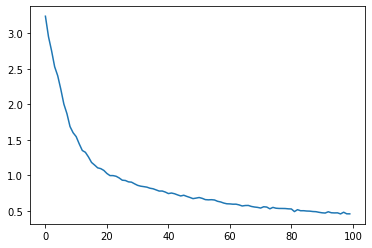

CPU times: user 7.13 s, sys: 91.7 ms, total: 7.22 s
Wall time: 7.73 s


In [4]:
%%time
model = MyModel()
optimizer=tf.keras.optimizers.Adam()

loss_averages = []
for epoch in range(100):
    batch = return_tf_batch(X_train, Y_train, batch_size=10)
    loss_values = []
    for (x,y) in batch:
        loss_value = update(x, y, model, optimizer)
        loss_values.append(loss_value)
    loss_averages.append(np.average(loss_values))
    
plt.plot(np.arange(100), loss_averages); plt.show()

比較してみると、同じ設定のはずなのに [3-1. この節の目標](#3-1-この節の目標) での実装に比べると少し実行速度が遅いです。
これは、いまの実装を[eager mode](https://www.tensorflow.org/guide/eager) と言われる状態で実行しているためです。eager modeとは、TensorFlowのバージョン2からデフォルトでonになった機能で、プログラムの試作がやりやすいぶん、実行速度の最適化がされないのです。もともと、tensorflowは
1. 計算グラフを作る
2. 作ったグラフに計算フローを入れる

から構成されており、そのように書いたほうが早くなります。この書き方は少し上記の書き方とは異なるため、速度を取るか、わかりやすさを取るか、というところです。

#### `tf.function`によるグラフ化で高速化
が、実は今回は`batch.step`を定義する前に
- `@tf.function`

と宣言すると数倍倍早くなります。`@`で始まる文法はPythonの**デコレータ** というものですので、気になる人は調べてみてください。ともかくこのデコレータを関数の定義の前につけると、その関数の処理を「グラフ化 $\to$ 計算フロー」のやり方に勝手に変換してくれます。これでわかりやすく高速な処理ができる場合があります。
> ただし、予期せぬ動作が起こる可能性があることが、TensorFlowのドキュメントの [Python の状態に注意](https://www.tensorflow.org/tutorials/customization/performance?hl=ja) で説明されていますので、高速化を図る際は一読をお勧めします。

In [27]:
@tf.function
def update(X, Y, model, optimizer): # 学習ステップ
    with tf.GradientTape() as tape:
        Y_pred = model(X) 
        loss_value = L(Y, Y_pred) 
    grads = tape.gradient(loss_value, model.trainable_variables) 
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss_value

学習の命令は**一行も書き換えていません**が、早くなります：

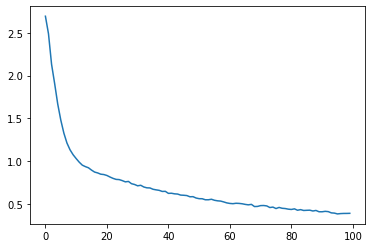

CPU times: user 1.86 s, sys: 182 ms, total: 2.05 s
Wall time: 1.72 s


In [28]:
%%time
model = MyModel()
optimizer=tf.keras.optimizers.Adam()

loss_averages = []
for epoch in range(100):
    batch = return_tf_batch(X_train, Y_train, batch_size=10)
    loss_values = []
    for (x,y) in batch:
        loss_value = update(x, y, model, optimizer)
        loss_values.append(loss_value)
    loss_averages.append(np.average(loss_values))
    
plt.plot(np.arange(100), loss_averages); plt.show()

### 序盤の実装
節の初めにお見せした実装はこんなに長くありませんでした。これは`tf.keras`のAPIを使ったおかげです。同じモデルを使って

In [30]:
model = MyModel()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

としておけば、自分でパラメータ更新用の関数を定義しなくてもパラメータを学習させられます。それには `model.fit()`を使います。オプションが幾つかあるのですが、ここで`verbose`はパラメータ更新中の経過をどのように表示するかのオプションで、0は何も表示しない、です。1か2を入れてもいいです。

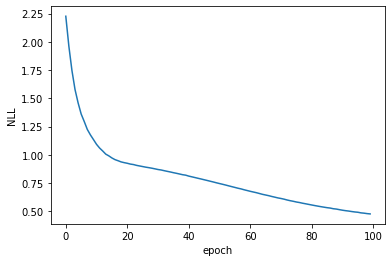

CPU times: user 1.99 s, sys: 245 ms, total: 2.24 s
Wall time: 1.72 s


In [31]:
%%time
Hist= model.fit(X_train, Y_train, epochs=100, batch_size=10, verbose=0)

plt.xlabel("epoch"); plt.ylabel("NLL")
plt.plot(np.arange(100), Hist.history['loss']);plt.show()

ほぼすべてのプロセスが自動化されており、計算スピードもここまで説明してきた中で最速です。だったらこれだけ使えばよいのでは？と思う方もいらっしゃるかと思いますが、`model.fit()`は早くて楽ちんな分、カスタマイズ性の面でこれまでの実装法に劣ります。目的に応じてこれらを使い分けるのが良いと思います。

### 検証(Validation)
確率的勾配降下法でできるだけ汎化誤差を減らす努力をするものの、基本的には学習データ $\mathcal{D}_N$ しかない状況の場合、データの偏りを回避することはできません。例えば反復回数を大きく取りすぎると、同じデータ点$({\bf x}_n, {\bf y}_n)$への遭遇回数も上がってしまい、それに過剰適合する可能性も大いにありえます。過剰適合を確実に回避するテクニックとして使われるのが検証です。検証の基本的なアイデアは、学習前にデータを分割し

$$
\mathcal{D}_N=
\mathcal{D}_{N_\text{train}}
\cup
\mathcal{D}_{N_\text{val}},
\quad
N_\text{train} + N_\text{val} = N
$$

$\mathcal{D}_{N_\text{train}}$について、確率的勾配降下法を適用し、適当な間隔で$\mathcal{D}_{N_\text{val}}$を用いた経験誤差の値もモニターします。$\mathcal{D}_{N_\text{val}}$の中のデータは学習に用いられないため、学習用の誤差が減っているのもかかわらず検証の誤差が増加し始めた場合、過剰適合のシグナルと思えるわけです。

#### 実装
データの取扱いだけが問題です。これまで通りやるなら、一旦初めにデータを分割しておいて、上の式で $\mathcal{D}_{N_\text{train}}$ だけを学習用データとし、$\mathcal{D}_{N_\text{val}}$ のデータを用いた誤差も更新時にモニターしておくのが良いでしょう。幸い`model.fit()`だと**一変数：`validation_split`を設定するだけ** で勝手にやってくれます。`validation_split=0.2`はデータのうち二割をランダムに選び、検証用としてくれるということです。

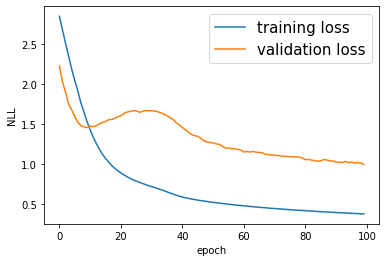

In [48]:
model = MyModel()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

Hist= model.fit(X_train, Y_train, epochs=100, batch_size=10, verbose=0, 
                validation_split=0.2) # これだけ追加

plt.xlabel("epoch"); plt.ylabel("NLL")
plt.plot(np.arange(100), Hist.history['loss'], label='training loss')
plt.plot(np.arange(100), Hist.history['val_loss'], label='validation loss') # プロット用にこれも追加
plt.legend(fontsize=15); plt.show()

これを見ると、（実行時の乱数シードに依存してうまく行ってしまう場合もありますが）
- training loss $L(\theta; \mathcal{D}_{N_\text{train}})$ は減り続ける
- validation loss $L(\theta; \mathcal{D}_{N_\text{val}})$ は減り、途中で上がる

のがわかります。validation lossは実際に最適化している経験誤差**ではない** のがポイントです。validation lossはいわば、学習後のタスクの精度を簡単にモニターしているようなものなので、この値が減っている分には汎化誤差を減らしていると期待できますが、上がり続けると過剰適合のシグナルです。
> 上の実験ではたまに、validation lossが下がる$\to$上がる$\to$また下がる、といった二重降下現象が起こります。